# Softmax exercise

*Complete this exercise and enclude results and output graphs along with desribtions of the model and development method in the assignment submission.

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'


# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del HAM_train_data
   del HAM_val_data
   del HAM_test_data
   print('Clear previously loaded data.')
except:
   pass


# Load the training and tuning datasets.
os.chdir(os.path.join(os.getcwd(), 'datasets/HAM_modified'))
HAM_train_data = np.load('HAM_train.npz',allow_pickle=True)
HAM_val_data = np.load('HAM_val.npz',allow_pickle=True)
HAM_test_data = np.load('HAM_test.npz',allow_pickle=True)
os.chdir(os.path.join(os.getcwd(), '../..'))

#load and print header to view some info on the data and example data
header = HAM_train_data['header']
print('\n')
print(header)
print('\n')
print(HAM_train_data['images'][0].shape,HAM_train_data['meta'][0][:],'label: ',HAM_train_data['labels'][0])
print('\n')
X_train, y_train, train_meta = HAM_train_data['images'], HAM_train_data['labels'], HAM_train_data['meta']

X_val, y_val, val_meta = HAM_val_data['images'], HAM_val_data['labels'], HAM_val_data['meta']

X_test, y_test, test_meta = HAM_test_data['images'], HAM_test_data['labels'], HAM_test_data['meta']

#labels are of type np.float32 but need to be converted into uint 8 for use for slicing later
y_train = np.array([int(i) for i in y_train])
y_val = np.array([int(i) for i in y_val])
y_test = np.array([int(i) for i in y_test])

# shuffle
train_arr = list(zip(X_train, y_train))
random.shuffle(train_arr)

X_train, y_train = zip(*train_arr)
X_train = np.array(X_train)
y_train = np.array(y_train)

val_arr = list(zip(X_val, y_val))
random.shuffle(val_arr)

X_val, y_val = zip(*val_arr)
X_val = np.array(X_val)
y_val = np.array(y_val)

test_arr = list(zip(X_test, y_test))
random.shuffle(test_arr)

X_test, y_test = zip(*test_arr)
X_test = np.array(X_test)
y_test = np.array(y_test)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Training meta info shape: ', train_meta.shape)
print('\n')
print('Val data shape: ', X_val.shape)
print('Val labels shape: ', y_val.shape)
print('Val meta info shape: ', val_meta.shape)
print('\n')
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Test meta info shape: ', test_meta.shape)



['image_array' 'image_id' 'dx' 'dx_type' 'age' 'sex' 'localization']


(48, 48, 3) ['ISIC_0028005' 'nv' 'follow_up' '45.0' 'male' 'trunk'] label:  2.0


Training data shape:  (13932, 48, 48, 3)
Training labels shape:  (13932,)
Training meta info shape:  (13932, 6)


Val data shape:  (2821, 48, 48, 3)
Val labels shape:  (2821,)
Val meta info shape:  (2821, 6)


Test data shape:  (2866, 48, 48, 3)
Test labels shape:  (2866,)
Test meta info shape:  (2866, 6)


Number of classes = 3


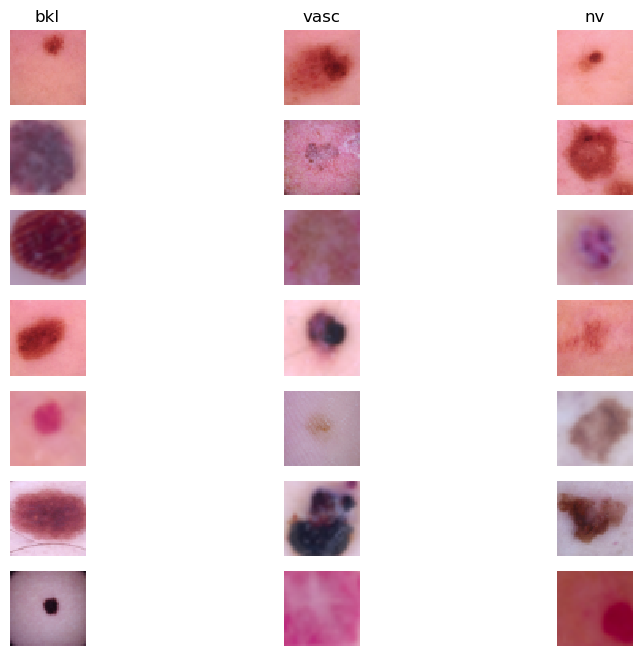

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
# we are going to be classifying three different types of 
# skin lesion on images sampled and modified from the HAM10000 data-set:
# https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T 


class_dict = {'bkl':'benign keratosis-like lesions', 
               'vasc':'vascular lesions', 
               'nv':'melanocytic nevi'}


num_classes = len(class_dict.keys())

print('Number of classes = {}'.format(num_classes))

samples_per_class = 7
for y, cls in enumerate(class_dict.keys()):
    idxs = np.where(train_meta[:] == cls)[0]
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# The data is alreade split the into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.

num_dev = 500

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(X_train.shape[0], num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]


print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Dev data shape: ', X_dev.shape)
print('Dev labels shape: ', y_dev.shape)

Train data shape:  (13932, 48, 48, 3)
Train labels shape:  (13932,)
Validation data shape:  (2821, 48, 48, 3)
Validation labels shape:  (2821,)
Test data shape:  (2866, 48, 48, 3)
Test labels shape:  (2866,)
Dev data shape:  (500, 48, 48, 3)
Dev labels shape:  (500,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (13932, 6912)
Validation data shape:  (2821, 6912)
Test data shape:  (2866, 6912)
dev data shape:  (500, 6912)


[192.56496 144.48407 155.54823 193.51831 145.14003 156.4786  194.35071
 145.6503  157.23729 195.01694]


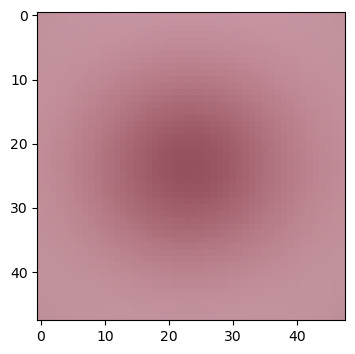

(13932, 6913) (2821, 6913) (2866, 6913) (500, 6913)


In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((48,48,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## Softmax Classifier

Your code for this section will all be written inside `classifiers/softmax.py`.


In [8]:
# First implement the naive softmax loss function with nested loops.
# Open the file classifiers/softmax.py and implement the
# softmax_loss_naive function.

from classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(6913, 3) * 0.0001 
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.33).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.33)))

loss: 1.261092
sanity check: 1.108663


**Inline Question**

Include in the report why we expect our loss to be close to -log(0.33)? Explain briefly.**

We expect this as we are using random weights, thus the predictions should basically be a random guess. Since we have 3 classes, we would guess our score to be 1/3.


In [9]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from classifiers.Deep_learning_course.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 2.703637 analytic: 2.703638, relative error: 1.297502e-08
numerical: -2.088971 analytic: -2.088971, relative error: 5.292248e-09
numerical: -8.250922 analytic: -8.250922, relative error: 5.577947e-09
numerical: -6.238197 analytic: -6.238197, relative error: 3.336438e-09
numerical: 11.529750 analytic: 11.529750, relative error: 6.320700e-09
numerical: 4.889745 analytic: 4.889745, relative error: 1.836861e-10
numerical: 9.986510 analytic: 9.986510, relative error: 7.149168e-09
numerical: 3.294623 analytic: 3.294623, relative error: 1.277465e-08
numerical: -6.138204 analytic: -6.138204, relative error: 2.581266e-09
numerical: 0.864949 analytic: 0.864949, relative error: 9.782568e-08
numerical: -7.271267 analytic: -7.271267, relative error: 9.725580e-10
numerical: 9.071983 analytic: 9.071983, relative error: 4.914849e-09
numerical: 7.759375 analytic: 7.759375, relative error: 7.396848e-09
numerical: -4.760093 analytic: -4.760093, relative error: 4.340053e-09
numerical: 7.826208 

In [13]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))
print('Naive gradient: {}'.format(grad_naive))

from classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))
print('Vectorized gradient: {}'.format(grad_vectorized))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 1.261092e+00 computed in 0.339803s
Naive gradient: [[ 5.02730122  1.44376559 -6.47106681]
 [ 0.44506827  2.65530518 -3.10037345]
 [ 1.29600779  1.73426749 -3.03027528]
 ...
 [ 1.11987899  1.47417349 -2.59405248]
 [ 1.45976786 -0.69439949 -0.76536837]
 [ 0.02501077 -0.04150892  0.01649815]]
vectorized loss: 1.261092e+00 computed in 0.015991s
Vectorized gradient: [[ 5.02730122  1.44376559 -6.47106681]
 [ 0.44506827  2.65530518 -3.10037345]
 [ 1.29600779  1.73426749 -3.03027528]
 ...
 [ 1.11987899  1.47417349 -2.59405248]
 [ 1.45976786 -0.69439949 -0.76536837]
 [ 0.02501077 -0.04150892  0.01649815]]
Loss difference: 0.000000
Gradient difference: 0.000000


In [17]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths.

from classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-7, 5e-5]
learning_rate_steps = 5
learning_rate_step_size = (learning_rates[1] - learning_rates[0]) / learning_rate_steps

regularization_strengths = [2.5e4, 5e4]
regularization_strength_steps = 5
regularization_strength_step_size = (regularization_strengths[1] - regularization_strengths[0]) / regularization_strength_steps

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for lr_step in range(learning_rate_steps):
    for rs_step in range(regularization_strength_steps):
        lr = lr_step * learning_rate_step_size + learning_rates[0]
        rs = rs_step * regularization_strength_step_size + regularization_strengths[0]
        print(f"Iteration with following params: lr - {lr} | rs - {rs}")

        softmax = Softmax()
        softmax.train(X_train, y_train, learning_rate=lr, reg=rs,
                      num_iters=1500, verbose=True)

        y_train_pred = softmax.predict(X_train)
        train_accuracy = np.mean(y_train == y_train_pred)
        print(f"Train Accuracy: {train_accuracy:.5}")

        y_val_pred = softmax.predict(X_val)
        val_accuracy = np.mean(y_val == y_val_pred)
        print(f"Validation Accuracy: {val_accuracy:.5}")

        results[(lr, rs)] = (train_accuracy, val_accuracy)

        if val_accuracy > best_val:
            best_val = val_accuracy
            best_softmax = softmax


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

Iteration with following params: lr - 1e-07 | rs - 25000.0
iteration 0 / 1500: loss 257.508318
iteration 100 / 1500: loss 155.345423
iteration 200 / 1500: loss 94.348478
iteration 300 / 1500: loss 57.532279
iteration 400 / 1500: loss 35.094392
iteration 500 / 1500: loss 21.578059
iteration 600 / 1500: loss 13.411450
iteration 700 / 1500: loss 8.377323
iteration 800 / 1500: loss 5.416189
iteration 900 / 1500: loss 3.581403
iteration 1000 / 1500: loss 2.442997
iteration 1100 / 1500: loss 1.850325
iteration 1200 / 1500: loss 1.370653
iteration 1300 / 1500: loss 1.187985
iteration 1400 / 1500: loss 0.949654
Train Accuracy: 0.75136
Validation Accuracy: 0.75611
Iteration with following params: lr - 1e-07 | rs - 30000.0
iteration 0 / 1500: loss 306.608218
iteration 100 / 1500: loss 167.430424
iteration 200 / 1500: loss 92.074452
iteration 300 / 1500: loss 50.737136
iteration 400 / 1500: loss 28.194365
iteration 500 / 1500: loss 15.774384
iteration 600 / 1500: loss 8.998591
iteration 700 / 150

c:\Users\madsh\OneDrive\Software_engineering\9. semester\Deep Learning\Assignments\assignment1\classifiers\softmax.py:86: RuntimeWarning: divide by zero encountered in log
  sum_j = np.sum(np.exp(scores), axis=1)


iteration 100 / 1500: loss 201.361272
iteration 200 / 1500: loss 169.084320
iteration 300 / 1500: loss 157.801749
iteration 400 / 1500: loss 127.341821
iteration 500 / 1500: loss 147.520479
iteration 600 / 1500: loss 159.303320
iteration 700 / 1500: loss 195.568287
iteration 800 / 1500: loss 170.192244
iteration 900 / 1500: loss 128.798837
iteration 1000 / 1500: loss 164.603108
iteration 1100 / 1500: loss 135.333442
iteration 1200 / 1500: loss 163.362219
iteration 1300 / 1500: loss 148.774811
iteration 1400 / 1500: loss 148.673932
Train Accuracy: 0.40633
Validation Accuracy: 0.38426
Iteration with following params: lr - 4.002e-05 | rs - 25000.0
iteration 0 / 1500: loss 264.182895
iteration 100 / 1500: loss 69.881980
iteration 200 / 1500: loss 59.322508
iteration 300 / 1500: loss 65.828749
iteration 400 / 1500: loss 71.348510
iteration 500 / 1500: loss 69.251663
iteration 600 / 1500: loss 64.966351
iteration 700 / 1500: loss 86.332736
iteration 800 / 1500: loss 103.339809
iteration 900 

In [18]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.760293


**Inline Question** 

Consider the following. Include in your report if you think it adds value:

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.



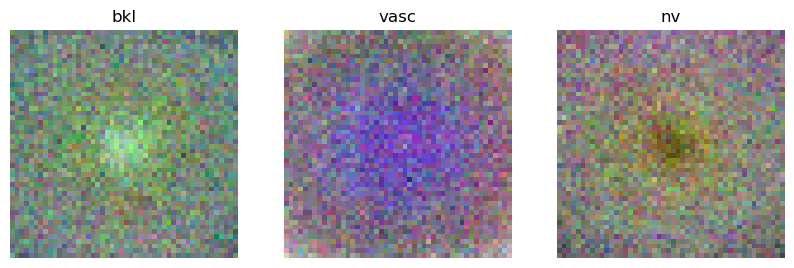

In [19]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(48, 48, 3, 3)

w_min, w_max = np.min(w), np.max(w)

classes = ['bkl', 'vasc','nv']
for i in range(3):
    plt.subplot(1, 3, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

**Inline Question**

In the report, describe what your visualized weights look like, and offer a brief explanation for why they look the way they do in comparisson to the SVM weights.
